<h2><center>Starter Code for Docking ISS</center></h2>

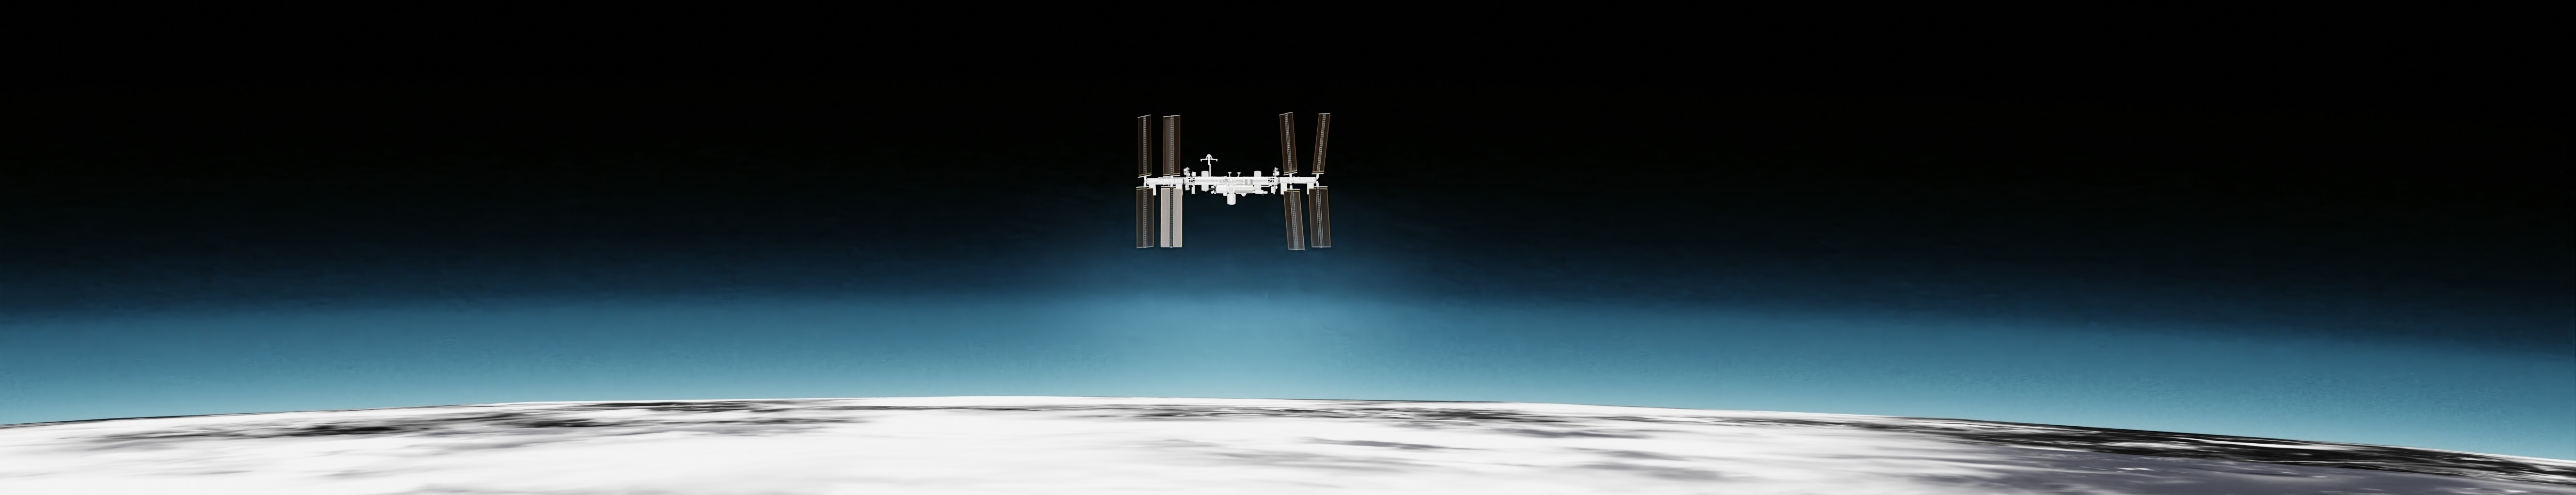
### What we are going to Learn

  - Image Classification using Pytorch
  - Creating & Training multi output predictions using pretrained resnet model   
  - Testing and Submitting the Results to the Challenge. 

**Note : Create a copy of the notebook and use the copy for submission. Go to *File > Save a Copy in Drive* to create a new copy**

# Setting up Environment

### Downloading Dataset

So we will first need to download the python library by AIcrowd that will allow us to download the dataset by just inputting the API key. 

In [ ]:
!pip install aicrowd-cli

%load_ext aicrowd.magic

     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 174kB 14.7MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 215kB 43.4MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.26.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
%aicrowd login

In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c docking-iss -o data

train.csv: 100% 217k/217k [00:00<00:00, 2.55MB/s]
train.zip: 100% 150M/150M [00:01<00:00, 93.9MB/s]
val.csv: 100% 20.8k/20.8k [00:00<00:00, 2.28MB/s]
val.zip: 100% 15.5M/15.5M [00:00<00:00, 18.2MB/s]


In [ ]:
# Unzipping the files
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

Streaming output truncated to the last 5000 lines.
  inflating: data/train/6002.jpg     
  inflating: data/train/6003.jpg     
  inflating: data/train/6004.jpg     
  inflating: data/train/6005.jpg     
  inflating: data/train/6006.jpg     
  inflating: data/train/6007.jpg     
  inflating: data/train/6008.jpg     
  inflating: data/train/6009.jpg     
  inflating: data/train/6010.jpg     
  inflating: data/train/6011.jpg     
  inflating: data/train/6012.jpg     
  inflating: data/train/6013.jpg     
  inflating: data/train/6014.jpg     
  inflating: data/train/6015.jpg     
  inflating: data/train/6016.jpg     
  inflating: data/train/6017.jpg     
  inflating: data/train/6018.jpg     
  inflating: data/train/6019.jpg     
  inflating: data/train/6020.jpg     
  inflating: data/train/6021.jpg     
  inflating: data/train/6022.jpg     
  inflating: data/train/6023.jpg     
  inflating: data/train/6024.jpg     
  inflating: data/train/6025.jpg     
  inflating: data/train/6026.jpg     

### Downloading & Importing Libraries

Here we are going to use PyTorch to do our multioutput tasks, while [PyTorch](https://pytorch.org/) is really popular deep learning model, for those who are new to PyTorch, pytorch is an open source Deep Learning Library thay helps in creating, training Deep Learning Models, and much more. 

We are also going to use [pretrainedmodels.pytorch](https://github.com/Cadene/pretrained-models.pytorch)  which provides tons of pretrained deep learning models, such as resnets, vgg or efficientnets.  

In [ ]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 4.4MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=9ebcecc0757bd02aa4dc588344418e444b1aefee1ce510b9a0dc52a69878c45f
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [ ]:
# PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

# Pretrained Models
import pretrainedmodels

# Reading Dataset & Visualizations
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

# Misc
import os
from tqdm import trange
from tqdm.notebook import tqdm
import random

# Using GPU for training if GPU is detected, else, CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Make Sure your GPU is enabled by going in tab **Runtime** > **Change Runtime Type** > **Hardware Accelerator** > **GPU**

# Training phase ⚙️

## Reading Dataset

Reading the necessary files to train, validation & submit our results! 

In [ ]:
# Reading the training dataset
train_df = pd.read_csv("data/train.csv")
train_df

,ImageID,distance,location
0,0,351,"[215, 158]"
1,1,372,"[228, 269]"
2,2,488,"[255, 386]"
3,3,308,"[306, 426]"
4,4,67,"[248, 338]"
...,...,...,...
9995,9995,409,"[231, 386]"
9996,9996,307,"[280, 103]"
9997,9997,270,"[280, 490]"
9998,9998,390,"[228, 110]"


## Data Visualization

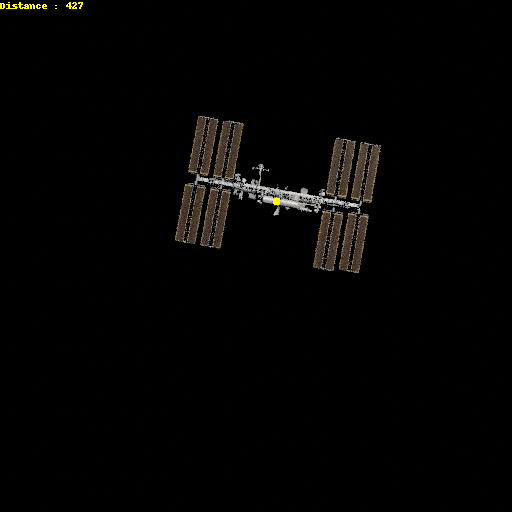

In [ ]:
# Reading a ramdom sample
sample_index = random.randint(0, train_df.shape[0]-1)

# Reading the image
img = Image.open(f"data/train/{train_df['ImageID'][sample_index]}.jpg")

# Getting the distance and location of the specific image
distance = train_df['distance'][sample_index]
location = eval(train_df['location'][sample_index])

# Drawing the location and the distance
draw = ImageDraw.Draw(img)
x, y, r = location[0], location[1], 3
points = (x-r, y-r, x+r, y+r)
draw.ellipse(points, "yellow")
draw.text((0, 0),f"Distance : {distance}","yellow")

img

## Creating the Dataset

In [ ]:
class ISSDataset(Dataset):

  def __init__(self, img_directory, csv_path=None, train=True):
    
    # Images directory and reading corrospoding csv
    self.img_directory = img_directory
    self.train = train
    self.data = pd.read_csv(csv_path)

  def __len__(self):
    return len(os.listdir(self.img_directory))

  def __getitem__(self, idx):

    img_id = self.data['ImageID'][idx]

    # Reading the image
    img_path = os.path.join(self.img_directory, f"{img_id}.jpg")
    img = Image.open(img_path)
    img = np.array(img)
    img = np.moveaxis(img, -1, 0) # Converting from image channel ordering from last channel to first channel  

    # If the dataset is set to train
    if self.train == True:
      
      # Reading the labels
      distance = self.data[self.data['ImageID'] == img_id]['distance'].values[0]
      location = eval(self.data[self.data['ImageID'] == img_id]['location'].values[0])

      label = [distance, location[0], location[1]]


      return img, label
    
    # If dataset is set to testing data
    else:

      return img, img_id

In [ ]:
# Reading the training dataset
train_iss_dataset = ISSDataset(csv_path="data/train.csv", img_directory="data/train/")
train_dataset = DataLoader(train_iss_dataset, batch_size=4, shuffle=True)

# Reading the validation dataset
val_iss_dataset = ISSDataset(csv_path="data/val.csv", img_directory="data/val/")
val_dataset = DataLoader(val_iss_dataset, batch_size=4, shuffle=True)

In [ ]:
# Going through a sample of the the dataset
feature, labels = next(iter(train_dataset))

[tensor([305, 285]), tensor([305, 234]), tensor([252, 311])]

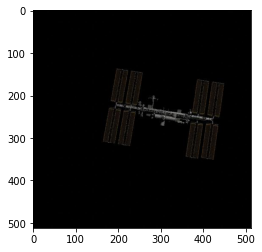

In [ ]:
# Showing the image with label
img = np.moveaxis(feature[0].numpy(), 0, -1)
plt.imshow(img)
labels

## Creating the Model

Using a Pretrained Resnet18 model and adding three fully connected layers to predict - 
* Distance
* Location in X axis
* Location in Y axis

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    # Using a pretrained mdoel
    self.model = pretrainedmodels.__dict__["resnet18"](pretrained="imagenet")

    # Creating 3 fully connected layers 
    self.distance_fc = nn.Linear(512, 1)
    self.location_fc_x = nn.Linear(512, 1)
    self.location_fc_y = nn.Linear(512, 1)

  # Takingt the image and predicting the labels 
  def forward(self, image):
     
    batch_size = image.shape[0]

    image = image.to(torch.float32)

    x = self.model.features(image)
    x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)

    distance = self.distance_fc(x)
    location_x = self.location_fc_x(x)
    location_y = self.location_fc_y(x)

    return distance, location_x, location_y

model = Model()
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
# Sample Predictions
sample_predictions = model(feature)
sample_predictions

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(tensor([[1.1384],
         [1.1928]], grad_fn=<AddmmBackward>), tensor([[0.5918],
         [0.2540]], grad_fn=<AddmmBackward>), tensor([[0.1508],
         [0.2556]], grad_fn=<AddmmBackward>))

## Setting up Parameters

Here we will be setting up few parameters including Loss, Optimizer, Learning Rate and function for the trainign

In [ ]:
# Loss
loss_function = nn.MSELoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# Training Function 
def train(dataloader, model, loss_function, optimizer, train=True):

  # Using GPU if GPU is detected
  model = model.to(device)
  losses = []

  # Grounf thought each batch 
  pbar = tqdm(dataloader) # Creating a progress bar
  for batch, (X, y) in enumerate(dataloader):
    
    # Ground truth
    y = [i.to(torch.float32).to(device).unsqueeze(1) for i in y]

    # Predictions
    pred = model(X.to(device))
    pred = [i.to(torch.float32)  for i in pred]

    # Calulating total loss for 3 predictions
    loss = loss_function(y[0], pred[0]) + loss_function(y[1], pred[1]) + loss_function(y[2], pred[2])

    # Doing backpropagation if train is set to true
    if train==True:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      pass

    # Updating the progress bar
    pbar.set_description(f"Batch : {batch} Loss : {loss.item()}")
    losses.append(loss.item())
    pbar.update(1)

  # Returning the mean loss
  return sum(losses)/len(losses)

## Training the Model
And there we go! It's finally the time to start the training!

In [ ]:
losses = train(dataloader=train_dataset, model=model, loss_function=loss_function, optimizer=optimizer)
print("Mean Loss over 1 Epoch : ", losses)

  0%|          | 0/5000 [00:00<?, ?it/s]

Mean Loss over 1 Epoch :  7547.396356729126


## Validation

Now we have trained the model, let's see the results for unseen set of images. 

In [ ]:
losses = train(dataloader=val_dataset, model=model, loss_function=loss_function, optimizer=optimizer, train=False)
print("Mean Loss over 1 Epoch ( Validation ) : ", losses)

  0%|          | 0/500 [00:00<?, ?it/s]

Mean Loss over 1 Epoch :  503.2519160079956


# Submitting Results 📄

Okay, this is the last section 😌 , let's get out testing results from the model real quick and submit our prediction directly using AIcrowd CLI

## Reading the Test Dataset

In [ ]:
test_dataset = ISSDataset(img_directory="data/test/", csv_path="data/submission.csv", train=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Function to take the dataset & model and return the predictions for all samples
def test(dataloader, model):

  # Loss containing predictions
  distances = []
  locations = []
  imageids = []

  model = model.to(device)

  # Going through each batch  
  for batch, (X, img_id) in tqdm(enumerate(dataloader)):

    # Getting the predictions
    pred = model(X.to(device))

    # Adding the distance
    distance = pred[0].cpu().detach().tolist()
    distances.extend([*distance])
    
    # Adding the Locations 
    location_x = pred[1].cpu().detach().tolist()
    location_y = pred[2].cpu().detach().tolist()
    location = [[x[0], y[0]]  for x, y in zip(location_x, location_y)]
    locations.extend(location)

    imageids.extend([*img_id.tolist()])

  return imageids, [d[0] for d in distances], locations

In [ ]:
# Running the inference
imageids, distances, locations = test(test_dataloader, model)

0it [00:00, ?it/s]

In [ ]:
# Adding the predictions to the submission.csv 
test_dataset.data.ImageID = imageids
test_dataset.data.distance = distances
test_dataset.data.location = locations
test_dataset.data

,ImageID,distance,location
0,0,321.930756,"[262.0217590332031, 203.3336944580078]"
1,1,463.857513,"[327.293212890625, 125.95026397705078]"
2,2,421.140198,"[230.29417419433594, 466.2022705078125]"
3,3,119.153801,"[284.049072265625, 489.627685546875]"
4,4,158.174683,"[214.08851623535156, 430.1171569824219]"
...,...,...,...
4995,4995,445.237427,"[237.29318237304688, 200.6291961669922]"
4996,4996,350.397552,"[253.53211975097656, 481.5347595214844]"
4997,4997,370.409882,"[225.88555908203125, 472.9713134765625]"
4998,4998,65.015976,"[293.5000915527344, 330.70587158203125]"



**Note : Please make sure that there should be filename `submission.csv` in `assets` folder before submitting it**

In [ ]:
# Saving the submission.csv in the assets folder 
!rm -rf assets
!mkdir assets

test_dataset.data.to_csv(os.path.join("assets", "submission.csv"), index=False)

## Uploading the Results

In [ ]:
!aicrowd notebook submit -c docking-iss -a assets --no-verify

Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWh9Q5rNtaDSqNf5ckoRGGWfxKO4AeTCKzS72eL34U7tgzeJdWdX9w8
Mounted at /content/drive
Using notebook: /content/drive/MyDrive/Colab Notebooks/Docking ISS for submission...
Scrubbing API keys from the notebook...
submissi

> Don't be shy to ask question related to any errors you are getting or doubts in any part of this notebook in [discussion forum](https://www.aicrowd.com/challenges/ai-blitz-10/problems/docking-iss/discussion) or in [AIcrowd Discord sever](https://discord.gg/T6uZSWBMSZ), AIcrew will be happy to help you :)

Also, wanna give us your valuable feedback for next blitz or wanna work with us creating blitz challanges ? Let us know! 